# Lecture 6 - Cross-Validation

```{contents}
:local:
:depth: 1
```

## Learning goals

- Use **KFold** and **cross_val_score** for fair evaluation.
- Tune hyperparameters with **GridSearchCV**.
- Explain predictions using **feature importance** and **permutation importance**.

  [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1vjb0L9j2XJ76u5xcmuGrl0P2O8tX-tzf?usp=sharing) 

---

## 1. Dataset and setup

```{admonition} Why this dataset?
We will reuse the same table from Lecture 5. It includes SMILES plus targets such as **Melting Point** and **Toxicity**. We compute four lightweight descriptors that we already trust: `MolWt`, `LogP`, `TPSA`, `NumRings`. They are fast to compute, easy to interpret, and good enough to demonstrate model selection and cross‑validation.
```

### 1.1 Imports and environment

In [1]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
#         %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None

from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, lasso_path
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

### 1.2 Load data and build descriptors

```{admonition} Data source
We will use this C-H oxidation dataset we saw before:  
`https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv`
```

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)

def calc_descriptors_row(smiles):
  m = Chem.MolFromSmiles(smiles)
  if m is None:
    return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
  return pd.Series({
            "MolWt": Descriptors.MolWt(m),
            "LogP": Crippen.MolLogP(m),
            "TPSA": rdMolDescriptors.CalcTPSA(m),
            "NumRings": rdMolDescriptors.CalcNumRings(m),
        })


desc_df = df_raw["SMILES"].apply(calc_descriptors_row)
df_reg_mp = pd.concat([df_raw, desc_df], axis=1)
df_reg_mp.head()

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0


```{admonition} What these features mean
- **MolWt**: molecular weight (sum of atomic masses).  
- **LogP**: hydrophobicity descriptor (octanol/water partition).  
- **TPSA**: topological polar surface area.  
- **NumRings**: ring count.
```

---

## 2. Quick Exploratory Data Analysis (EDA)

### 2.1 Descriptor histograms

```{admonition} Goal
Check scale, spread, and any extreme values. If a feature is highly skewed, consider transforms or standardization before training.
```

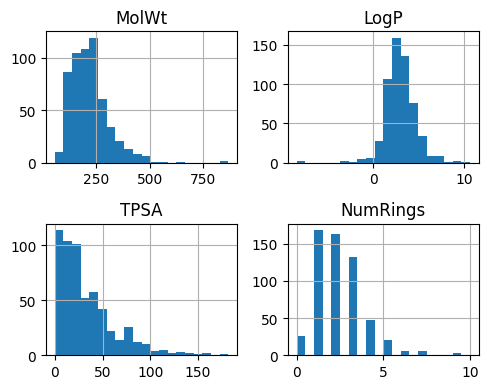

In [3]:
features = ["MolWt", "LogP", "TPSA", "NumRings"]
ax = df_reg_mp[features].hist(bins=20, figsize=(5,4))
plt.tight_layout()
plt.show()

### 2.2 Pairwise relationships

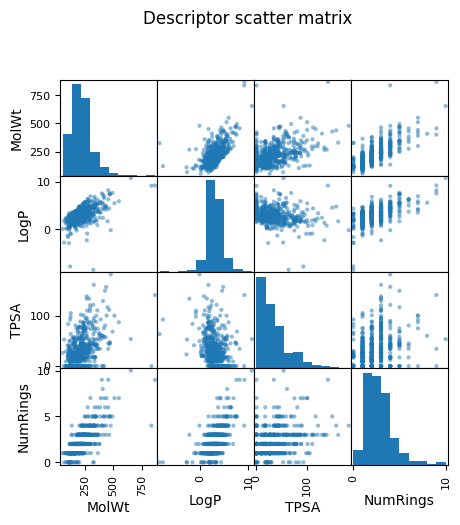

In [4]:
pd.plotting.scatter_matrix(df_reg_mp[features], figsize=(5,5))
plt.suptitle("Descriptor scatter matrix", y=1.02)
plt.show()

As you see above, a pairwise plot (also called a scatterplot matrix) shows relationships between every possible pair of features. For example, if you have four descriptors — MolWt, LogP, TPSA, and NumRings — the matrix will draw 12 scatterplots pairs (diagonal being their own distribution).

Why we look at pairwise plots?

**Spot correlations**: If two descriptors are strongly correlated (for example, heavier molecules often have higher logP), you can see it visually.  Highly correlated pairs may be redundant.

**Detect outliers**: Points that are far away from the general cloud of data stand out.



### 2.3 Redundancy demo and correlation

To illustrate what redundancy looks like, in the following example, we added a synthetic feature called `MolWt_half`, created simply by multiplying molecular weight by 0.5. In the scatter matrix, `MolWt_half` and `MolW` form a perfect straight-line relationship, highlighting redundancy.

In real-world datasets, you might encounter similar situations where two measured properties track one another closely because they arise from the same underlying physical or chemical trend. In such cases, redundancy reduces the effective dimensionality of the dataset.

This visual impression can be confirmed by calculating the correlation coefficient numerically. A correlation near `1.0` (or `–1.0`) indicates strong redundancy, just like we see between MolWt and MolWt_half.


Correlation Matrix (rounded to 3 decimals):
            MolWt   LogP   TPSA  NumRings  MolWt_half
MolWt       1.000  0.595  0.447     0.759       1.000
LogP        0.595  1.000 -0.268     0.605       0.595
TPSA        0.447 -0.268  1.000     0.294       0.447
NumRings    0.759  0.605  0.294     1.000       0.759
MolWt_half  1.000  0.595  0.447     0.759       1.000


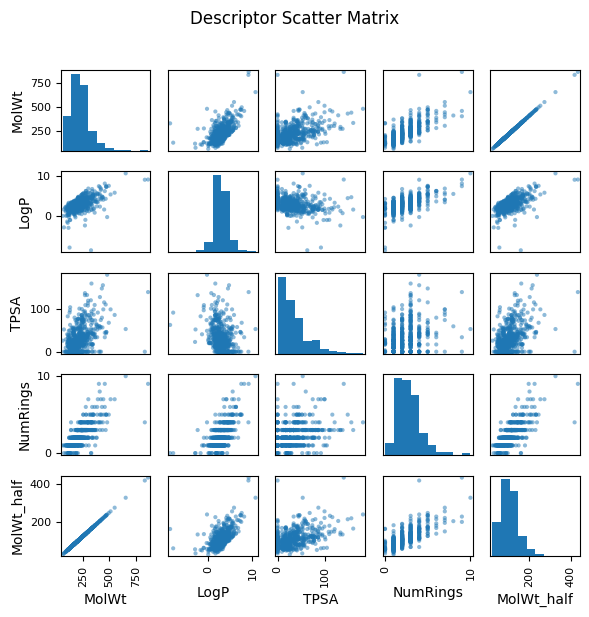

In [5]:
# Add demo redundant feature
df_reg_mp["MolWt_half"] = df_reg_mp["MolWt"] * 0.5

# Choose features to visualize
features = ["MolWt", "LogP", "TPSA", "NumRings", "MolWt_half"]

# Numerical correlation matrix
print("\nCorrelation Matrix (rounded to 3 decimals):")
corr_matrix = df_reg_mp[features].corr().round(3)
print(corr_matrix)

# Scatter matrix
pd.plotting.scatter_matrix(df_reg_mp[features], figsize=(6,6), diagonal="hist")
plt.suptitle("Descriptor Scatter Matrix", y=1.02)
plt.tight_layout()
plt.show()

---

## 3. Introduction to hyperparameters

```{admonition} Lasso refresher
Lasso solves a linear regression with an L1 penalty. The loss (on a dataset of size *n*) is  
\[
\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2 + \alpha \sum_j |w_j|
\]  
When \(\alpha\) is larger, more coefficients go to zero.
```

### 3.1 Single split evaluation
When we fit a model, we often think about weights (w) that are learned from the data. But some knobs are not learned automatically — they are chosen by us. These are called **hyperparameters**. One of the most important hyperparameters in Lasso is alpha. As you may recall from last lecture, it controls the strength of the L1 penalty.

In [6]:
# Define X (features) and y (target)
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_reg_mp["Melting Point"]

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Define models in a dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1, max_iter=500),
    "Lasso (alpha=1)":   Lasso(alpha=1,   max_iter=500),
    "Lasso (alpha=10)":  Lasso(alpha=10,  max_iter=500),
    "Lasso (alpha=100)": Lasso(alpha=100, max_iter=500),
    "Lasso (alpha=500)": Lasso(alpha=500, max_iter=500)
}

# Collect results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_val = mean_squared_error(y_test, y_pred)
    mae_val = mean_absolute_error(y_test, y_pred)
    r2_val  = r2_score(y_test, y_pred)

    results.append([name, mse_val, mae_val, r2_val])

# Put results in a nice DataFrame
df_results = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2"])
df_results

,Model,MSE,MAE,R2
0,Linear Regression,398.206541,16.006228,0.816101
1,Lasso (alpha=0.1),396.546775,15.975604,0.816868
2,Lasso (alpha=1),389.603474,15.816549,0.820074
3,Lasso (alpha=10),390.347484,15.855184,0.819731
4,Lasso (alpha=100),399.273984,16.080242,0.815608
5,Lasso (alpha=500),423.683879,16.757040,0.804335


### 3.2 Effect of alpha (plot)

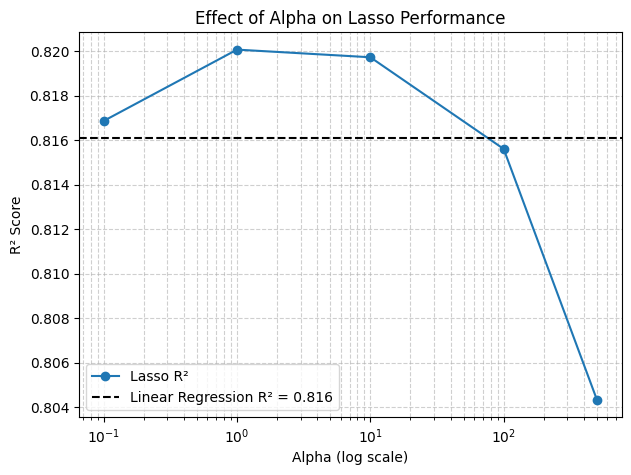

In [7]:
# Extract results for plotting
lasso_results = df_results[df_results["Model"].str.contains("Lasso")]
alphas = [0.1, 1, 10, 100, 500]
r2_scores = lasso_results["R2"].values

# Linear Regression baseline
linear_r2 = df_results.loc[df_results["Model"] == "Linear Regression", "R2"].values[0]

# Plot R² vs alpha
plt.figure(figsize=(7,5))
plt.semilogx(alphas, r2_scores, marker="o", label="Lasso R²")
plt.axhline(linear_r2, color="k", linestyle="--", label=f"Linear Regression R² = {linear_r2:.3f}")

plt.xlabel("Alpha (log scale)")
plt.ylabel("R² Score")
plt.title("Effect of Alpha on Lasso Performance")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()

---

## 4. Cross validation
So far we evaluated models with a single 80/20 split, which can give performance estimates that depend strongly on the random split. To obtain a more reliable measure, we can use **4-fold cross validation***. This way, the dataset is split into 4 equal parts, and each part is used once as the test set while the other 3 parts are used for training. The metrics are then averaged across the 4 folds.

```{admonition} Why CV?
A single split can overestimate or underestimate performance. K-fold CV repeats the split several times and averages the metric, giving a more stable estimate.
```

In [8]:
alphas = [0.1, 1, 10, 100]
kf = KFold(n_splits=4, shuffle=True, random_state=1)

for a in alphas:
    model = Lasso(alpha=a, max_iter=500)
    scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    print(f"alpha={a}, Scores on each fold: {scores} \n mean R²={scores.mean():.5f} \n")

alpha=0.1, Scores on each fold: [0.80086458 0.8800675  0.85024608 0.81400961] 
 mean R²=0.83630 

alpha=1, Scores on each fold: [0.8012391  0.88025613 0.85027326 0.81361778] 
 mean R²=0.83635 

alpha=10, Scores on each fold: [0.80123962 0.88012751 0.85111665 0.81276335] 
 mean R²=0.83631 

alpha=100, Scores on each fold: [0.79943866 0.87767314 0.85590684 0.80952064] 
 mean R²=0.83563 



```{admonition} Exercise 4.1
Change the alphas to `[0.05, 0.5, 1, 2, 5, 15, 30, 100]`.  
Use **5-fold** CV and the `neg_mean_squared_error` scorer.  
Print the per-fold values and the mean MSE.
```


---

## 5. Model selection, evaluation and prediction

```{admonition} Plan
Pick an alpha using CV, fit on train, evaluate on held‑out test, then apply to new molecules.
```

In [9]:
from sklearn.model_selection import KFold, cross_validate

# Define X and y again
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_reg_mp["Melting Point"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use 4-fold cross validation
kf = KFold(n_splits=4, shuffle=True, random_state=1)

# Same models as before
models = {
    "Linear Regression": LinearRegression(),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1, max_iter=500),
    "Lasso (alpha=1)":   Lasso(alpha=1,   max_iter=500),
    "Lasso (alpha=10)":  Lasso(alpha=10,  max_iter=500),
    "Lasso (alpha=30)": Lasso(alpha=30, max_iter=500),
    "Lasso (alpha=100)": Lasso(alpha=100, max_iter=500)
}

results_cv = []

for name, model in models.items():
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=kf,
        scoring=["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
        return_train_score=False
    )

    # Compute mean and std across folds
    mean_r2 = cv_results["test_r2"].mean()
    mean_mse = -cv_results["test_neg_mean_squared_error"].mean()
    mean_mae = -cv_results["test_neg_mean_absolute_error"].mean()

    results_cv.append([name, mean_mse, mean_mae, mean_r2])

# Put results in a DataFrame
df_results_cv = pd.DataFrame(results_cv, columns=["Model", "MSE", "MAE", "R2"])
print(df_results_cv)

               Model         MSE        MAE        R2
0  Linear Regression  410.132745  15.969645  0.832197
1  Lasso (alpha=0.1)  409.638038  15.958751  0.832326
2    Lasso (alpha=1)  408.902710  15.918428  0.832658
3   Lasso (alpha=10)  408.189050  15.900646  0.833132
4   Lasso (alpha=30)  408.099029  15.906188  0.833208
5  Lasso (alpha=100)  408.969334  15.961744  0.832932


Based on above table, you know alpha = 30 works best for this case.
Let's assign this value to build a model, fit with data and evaluate the outcome, which can be completed within three lines.

In [10]:
alpha_optimized_model = Lasso(alpha=30, max_iter=500)
fitted_lasso = alpha_optimized_model.fit(X_train, y_train)

print(f"Test R² = {r2_score(y_test, fitted_lasso.predict(X_test)):.3f} when we use alpha = 30")

Test R² = 0.818 when we use alpha = 30


R² = 0.820 tells us how good the fitting is. Note this R² is calculated based on the final hold-out test set, so it will be different from the R² one we see during the CV (0.833). The fact that they are very similar to each other is a good sign because this model has **never** seen any datapoint from `X_test` before but can still do a good prediction.

Now we can use this function to give prediction for points that are neither in train and test data set.
For example, we can predict two molecules's melting point by listing their descriptors.


```{admonition} Predict new points
We can predict from raw descriptors, or compute descriptors from SMILES first (see example below).
```

In [11]:
fitted_lasso.predict(pd.DataFrame([[100, 1.5, 10, 2],
                                   [150, 2.0, 20, 3]],
                                  columns=["MolWt", "LogP", "TPSA", "NumRings"]))

array([70.44917852, 95.30123863])

In [12]:
smiles_list = ["C1CCCC(C)C1", "CCCO"]

# Explicitly call your function for each SMILES
desc_rows = [calc_descriptors_row(s) for s in smiles_list]

# Build DataFrame
new_desc = pd.DataFrame(desc_rows)
new_desc

,MolWt,LogP,TPSA,NumRings
0,98.189,2.5866,0.00,1.0
1,60.096,0.3887,20.23,0.0


In [13]:
# Predict
two_new_preds = fitted_lasso.predict(new_desc)

# Show results
results = pd.DataFrame({"SMILES": smiles_list, "Prediction": two_new_preds})
print(results)

        SMILES  Prediction
0  C1CCCC(C)C1   69.345037
1         CCCO   51.000708


If your combine all above together, the workflow will look like:

1. Define features and target (`MolWt`, `LogP`, `TPSA`, `NumRings` → `Melting Point`).

2. Split data: 80% train, 20% test.

3. Model selection

*   Last lecture: fit on train directly if no hyperparameter tuning needed.
*   Lasso Regression (**this lecture**): use 4-fold cross-validation on train to pick best alpha, then refit on full train.

4. Evaluate chosen model on test set for generalization.

5. Apply final model to new molecules for prediction.


---

## 6. End‑to‑end workflow and grid search

```{admonition} Two ways to choose alpha
- Manual loop over a grid and pick the best mean CV score.  
- `GridSearchCV` to automate the loop, scoring, and refit.
```

Best alpha: 30 (mean R² = 0.833)
Test R² = 0.818
Linear Regression Test R² = 0.816


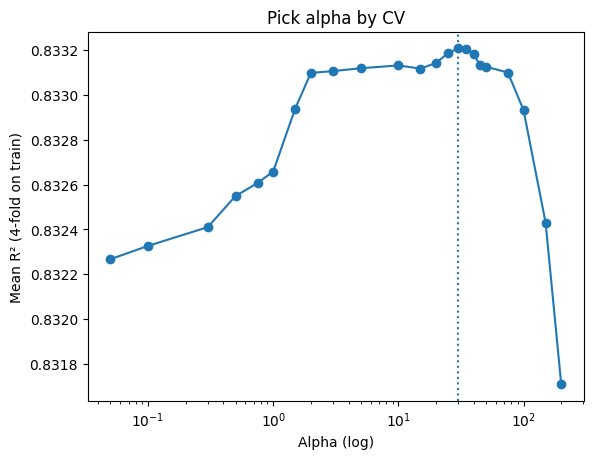

In [14]:
# 1) Features and target
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_reg_mp["Melting Point"]

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 3 Choose alpha using 4-fold CV on TRAIN ONLY
alphas = [0.05, 0.1, 0.3, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10,
          15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 150, 200]
kf = KFold(n_splits=4, shuffle=True, random_state=1)
mean_r2 = []
for a in alphas:
    model = Lasso(alpha=a, max_iter=500)
    r2_vals = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
    mean_r2.append(r2_vals.mean())
best_alpha = alphas[int(np.argmax(mean_r2))]
print(f"Best alpha: {best_alpha} (mean R² = {max(mean_r2):.3f})")

# 4) Fit with best alpha on TRAIN, evaluate on TEST
final_lasso = Lasso(alpha=best_alpha, max_iter=500).fit(X_train, y_train)

# 5) Evaluate
y_pred = final_lasso.predict(X_test)
print(f"Test R² = {r2_score(y_test, y_pred):.3f}")

# Optional: compare to plain Linear Regression
lr = LinearRegression().fit(X_train, y_train)
print(f"Linear Regression Test R² = {r2_score(y_test, lr.predict(X_test)):.3f}")

# Quick plot of the selection
plt.semilogx(alphas, mean_r2, marker="o")
plt.axvline(best_alpha, linestyle=":")
plt.xlabel("Alpha (log)"); plt.ylabel("Mean R² (4-fold on train)"); plt.title("Pick alpha by CV")
plt.show()

The block above actually shows a **manual** grid search: you loop through candidate alphas, run cross-validation, collect mean R² scores, and then pick the best alpha before refitting on the training set.

Now, the second block below shows the **same idea** implemented with `GridSearchCV`: it **automates** the loop, scoring, and best-alpha selection. With `refit=True`, the best model is automatically retrained on the full training data, so you can directly use `grid.best_estimator_` for evaluation.

In [15]:
# 1) Data
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_reg_mp["Melting Point"]

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 3a) Define model and CV
lasso = Lasso(max_iter=500)
param_grid = {"alpha": [0.05, 0.1, 0.3, 0.5, 0.75, 1, 1.5, 2, 3, 5,
                        10, 15, 20, 25, 30, 35, 40, 45, 50, 75,
                        100, 150, 200]}
cv = KFold(n_splits=4, shuffle=True, random_state=1)

# 3b) Grid search on TRAIN
grid = GridSearchCV(lasso, param_grid, cv=cv, scoring="r2", refit=True)
grid.fit(X_train, y_train)
print(f"Best alpha: {grid.best_params_['alpha']} (mean R^2 = {grid.best_score_:.3f})")

# 4) Best model (already fitted)
final_lasso = grid.best_estimator_

# 5) Evaluate on TEST
y_pred = final_lasso.predict(X_test)
print(f"Test R^2 = {r2_score(y_test, y_pred):.3f}")

Best alpha: 30 (mean R^2 = 0.833)
Test R^2 = 0.818


In [16]:
# 5) Predict on new molecules
smiles_three_new = ["C(F)(F)(F)CC=CCO", "C1CCCC(COC)C1", "CC(CBr)CCl"]

# Compute descriptors for each SMILES
smiles_three_new_desc = pd.DataFrame([calc_descriptors_row(s) for s in smiles_three_new])

# Predict for valid rows
smiles_three_new_preds = final_lasso.predict(smiles_three_new_desc)

# Show results
results = pd.DataFrame({"SMILES": np.array(smiles_three_new), "Prediction": smiles_three_new_preds})
print(results.to_string(index=False))

          SMILES  Prediction
C(F)(F)(F)CC=CCO   90.429280
   C1CCCC(COC)C1   84.337454
      CC(CBr)CCl  105.456027


We can also plot some representative molecules in train and test set, as well as some new molecules we want to predict outside the exisiting dataset.

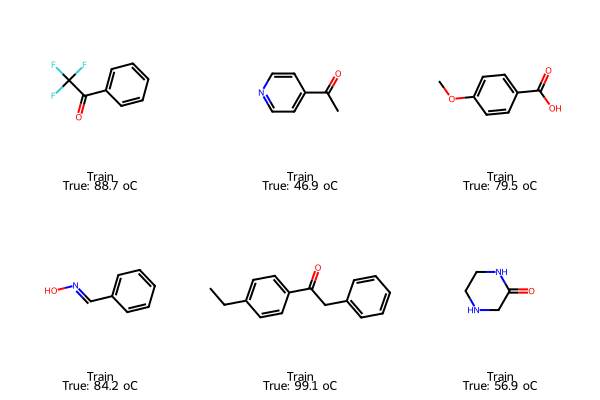

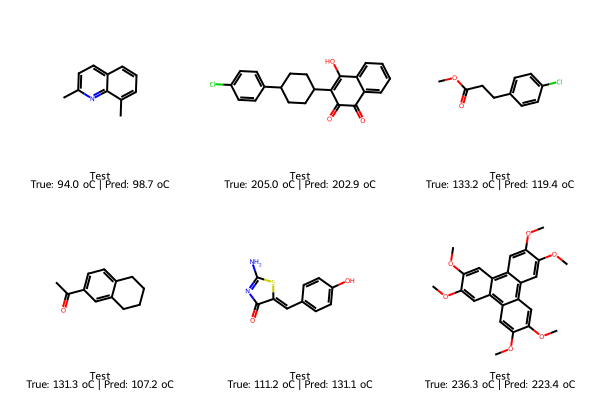

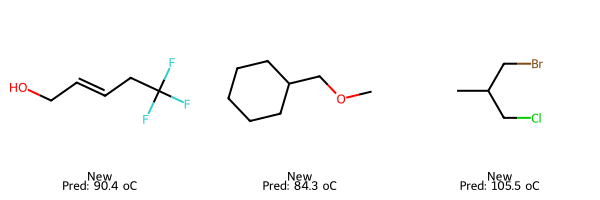

In [17]:
# Pick samples
train_idx = X_train.sample(6, random_state=101).index
test_idx  = X_test.sample(6,  random_state=202).index

# Train: true only
train_smiles = df_reg_mp.loc[train_idx, "SMILES"].tolist()
train_true   = y_train.loc[train_idx].tolist()
img_train = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in train_smiles],
    molsPerRow=3, subImgSize=(200,200),
    legends=[f"Train\nTrue: {t:.1f} oC" for t in train_true]
)

# Test: true and predicted
test_smiles = df_reg_mp.loc[test_idx, "SMILES"].tolist()
test_true   = y_test.loc[test_idx].tolist()
test_pred   = final_lasso.predict(X_test.loc[test_idx])
img_test = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in test_smiles],
    molsPerRow=3, subImgSize=(200,200),
    legends=[f"Test\nTrue: {t:.1f} oC | Pred: {p:.1f} oC"
             for t,p in zip(test_true, test_pred)]
)

# New: predicted only
smiles_new = ["C(F)(F)(F)CC=CCO", "C1CCCC(COC)C1", "CC(CBr)CCl"]
X_new = pd.DataFrame([calc_descriptors_row(s) for s in smiles_new])[final_lasso.feature_names_in_]
pred_new = final_lasso.predict(X_new)
img_new = Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in smiles_new],
    molsPerRow=3, subImgSize=(200,200),
    legends=[f"New\nPred: {p:.1f} oC" for p in pred_new]
)

display(img_train); display(img_test); display(img_new)

---

## 7. Explaining the model with feature importance

```{admonition} Two views
- **Coefficients**: direction and weight (Lasso shrinks some to zero).  
- **Permutation importance**: how much test R² drops when a feature is shuffled.
```

Lasso coefficients (feature importance):
MolWt       0.492808
TPSA        0.021167
LogP       -0.000000
NumRings   -0.000000
dtype: float64


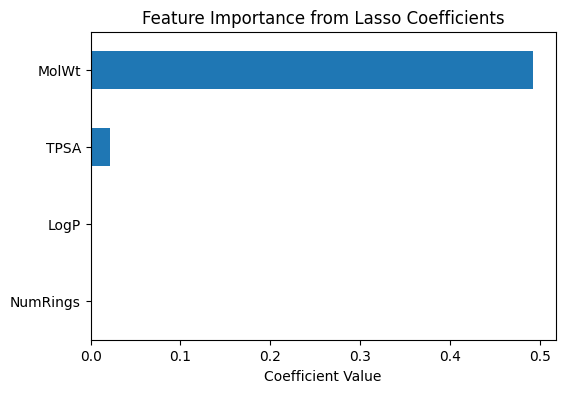


Permutation importance (mean decrease in R²):
LogP        0.000000
NumRings    0.000000
TPSA        0.002218
MolWt       1.607811
dtype: float64


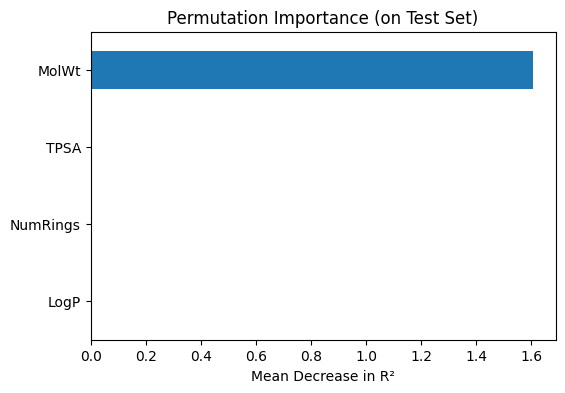

In [18]:
# --- Coefficient-based importance (Lasso) ---
coef_importance = pd.Series(
    final_lasso.coef_,
    index=final_lasso.feature_names_in_
).sort_values(key=abs, ascending=False)

print("Lasso coefficients (feature importance):")
print(coef_importance)

# Plot coefficients
coef_importance.plot(kind="barh", figsize=(6,4))
plt.title("Feature Importance from Lasso Coefficients")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()

# --- Permutation importance (model agnostic) ---
perm_importance = permutation_importance(
    final_lasso, X_test, y_test,
    scoring="r2", n_repeats=20, random_state=1
)

perm_series = pd.Series(
    perm_importance.importances_mean,
    index=final_lasso.feature_names_in_
).sort_values(ascending=True)

print("\nPermutation importance (mean decrease in R²):")
print(perm_series)

# Plot permutation importance
perm_series.plot(kind="barh", figsize=(6,4))
plt.title("Permutation Importance (on Test Set)")
plt.xlabel("Mean Decrease in R²")
plt.show()

---

## 8. Glossary

```{glossary}
Lasso Regression
  Linear regression with L1 regularization that can set some coefficients to exactly zero (feature selection).

Alpha (λ)
  Penalty strength in Lasso. Larger alpha increases regularization and may reduce the number of active features.

Cross validation (CV)
  Split the data into folds, train on k‑1 folds and validate on the held‑out fold; repeat and average.

R² (coefficient of determination)
  Measures how much variance the model explains. 1 is perfect, 0 matches the mean predictor.

MSE
  Mean of squared errors. Sensitive to large errors.

MAE
  Mean of absolute errors. More robust to outliers than MSE.

Permutation importance
  Test‑time feature shuffle to estimate performance drop for each feature.

Coefficient importance
  Weights in a linear model. In Lasso, many are shrunk to 0.

Feature redundancy
  Two or more features carry nearly the same information (high correlation).

GridSearchCV
  Scikit‑learn tool that evaluates parameter grids with CV and returns the best estimator.
```

---

## 9. Quick reference

```{admonition} Common scikit‑learn patterns
- Split: `train_test_split(X, y, test_size=0.2, random_state=...)`
- CV: `KFold(n_splits=4, shuffle=True, random_state=...)`
- Score: `cross_val_score(model, X, y, cv=kf, scoring="r2")`
- Grid search: `GridSearchCV(model, {"alpha":[...]}, cv=kf, scoring="r2", refit=True)`
- Metrics: `mean_squared_error`, `mean_absolute_error`, `r2_score`
```

```{admonition} Diagnostic plots
- **Parity**: predicted vs true (should hug the diagonal).  
- **Residuals**: residual vs prediction (should center near 0 without pattern).  
- **CV curve**: metric vs hyperparameter; pick the stable peak.
```

---

## 10. In‑class activity

Each task uses the functions and concepts above. Fill in the `...` lines. 
### Q1. Prepare log‑solubility and visualize

Prepare log-solubility, split 80/20 (seed=15), and visualize.

1. Create `y_log· = log10(Solubility_mol_per_L + 1e-6)`, 
2. Set `X = [MolWt, LogP, TPSA, NumRings]`, 
3. Split 80/20 with `random_state=15`, 
4. Plot a histogram of `y_log`, then a pairwise scatter matrix of the four descriptors.

Hint: After spliting, keep t

```python
# TO DO
# y_log = ...
# X = ...
# X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=15)

# Plots
# ...
```

### Q2. Tune Ridge on the training split

- Search alphas on `np.logspace(-2, 3, 12)` using **5‑fold** CV on `(X_tr, y_tr)`  
- Report best alpha and mean CV R², then refit `Ridge(alpha=best)` on train

```python
# TO DO
# cv = KFold(n_splits=..., shuffle=..., random_state=...)
# alphas = ...
# ...
# ...
# ridge_best = Ridge(alpha=...).fit(..., ...)
# print(f"best alpha={...:.4f}  CV mean R2={max(...):.3f}")
```

### Q3. Evaluate Ridge on test and draw diagnostics

- Compute **MSE**, **MAE**, **R²** on `(X_te, y_te)`  
- Plot a parity plot and a residual plot

```python
# TO DO
# y_hat = ...
# print(f"Test MSE={...:.4f}  MAE={...:.4f}  R2={...:.3f}")
# Parity and residual plots
# ...
```

### Q4. Predict two new molecules (Ridge)

Use the trained Ridge to predict log‑solubility for:
- `[135.0, 2.0, 9.2, 2]`  
- `[301.0, 0.5, 17.7, 2]`

```python
# TO DO
# X_new = np.array([[135.0, 2.0, 9.2, 2],
#                   [301.0, 0.5, 17.7, 2]])
# y_new = ridge_best.predict(X_new)
# print(pd.DataFrame({"MolWt": X_new[:,0], "LogP": X_new[:,1], "TPSA": X_new[:,2], "NumRings": X_new[:,3],
#                     "Predicted log10(solubility)": y_new}))
```

### Q5. Interpret Ridge with coefficients and permutation importance

- Show coefficient magnitudes and signs  
- Compute permutation importance on the **test** split and plot

```python
# TO DO
# feat = ["MolWt","LogP","TPSA","NumRings"]
# coef_ser = ...
# coef_ser.plot(kind="barh"); ...

# perm = permutation_importance(...)
# perm_ser = ...
# perm_ser.plot(kind="barh"); ...
```

---





## 11. Solutions

### 11.1 Solution Q1

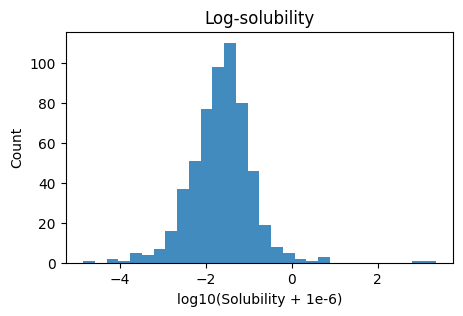

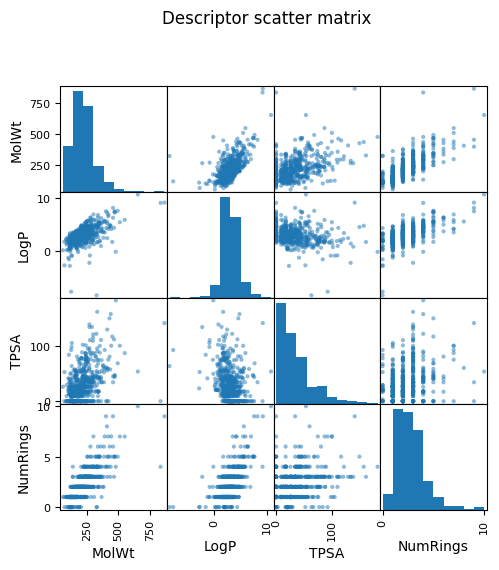

In [19]:
# Log target
df_reg_mp = df_reg_mp.copy()
y_log = np.log10(df_reg_mp["Solubility_mol_per_L"] + 1e-6)

# Features and split
X = df_reg_mp[["MolWt","LogP","TPSA","NumRings"]].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y_log, test_size=0.2, random_state=15)

# Plots
plt.figure(figsize=(5,3))
plt.hist(y_log, bins=30, alpha=0.85)
plt.xlabel("log10(Solubility + 1e-6)"); plt.ylabel("Count"); plt.title("Log-solubility")
plt.show()

pd.plotting.scatter_matrix(df_reg_mp[["MolWt","LogP","TPSA","NumRings"]], figsize=(5.5,5.5))
plt.suptitle("Descriptor scatter matrix", y=1.02); plt.show()

### 11.2 Solution Q2

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
alphas = np.logspace(-2, 3, 12)
means = [cross_val_score(Ridge(alpha=a), X_tr, y_tr, cv=cv, scoring="r2").mean() for a in alphas]
best_a = float(alphas[int(np.argmax(means))])
ridge_best = Ridge(alpha=best_a).fit(X_tr, y_tr)
print(f"best alpha={best_a:.4f}  CV mean R2={max(means):.3f}")

best alpha=1.8738  CV mean R2=0.968


### 11.3 Solution Q3

Test MSE=0.0160  MAE=0.1024  R2=0.970


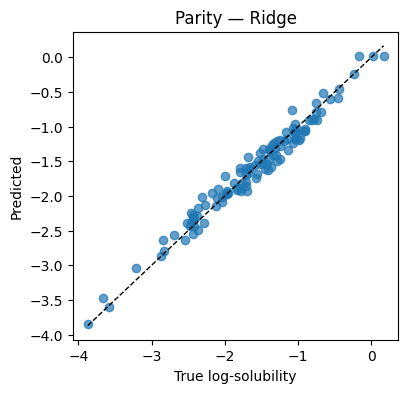

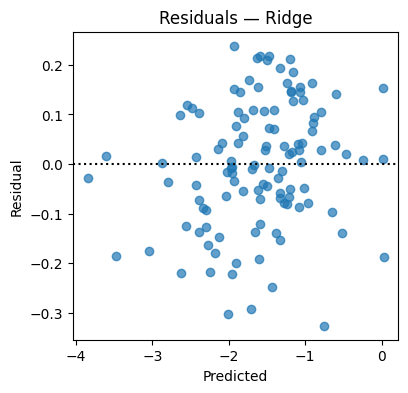

In [21]:
y_hat = ridge_best.predict(X_te)
print(f"Test MSE={mean_squared_error(y_te,y_hat):.4f}  "
      f"MAE={mean_absolute_error(y_te,y_hat):.4f}  "
      f"R2={r2_score(y_te,y_hat):.3f}")

plt.figure(figsize=(4.2,4))
plt.scatter(y_te, y_hat, alpha=0.7)
lims = [min(y_te.min(), y_hat.min()), max(y_te.max(), y_hat.max())]
plt.plot(lims, lims, "k--", lw=1)
plt.xlabel("True log-solubility"); plt.ylabel("Predicted"); plt.title("Parity — Ridge"); plt.show()

resid = y_te - y_hat
plt.figure(figsize=(4.2,4))
plt.scatter(y_hat, resid, alpha=0.7); plt.axhline(0, color="k", ls=":")
plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title("Residuals — Ridge"); plt.show()

### 11.4 Solution Q4

In [22]:
X_new = np.array([
    [135.0,  2.0,  9.2, 2],   # Molecule A
    [301.0,  0.5, 17.7, 2]    # Molecule B
])  # descriptors: [MolWt, LogP, TPSA, NumRings]

y_new = ridge_best.predict(X_new)
print(pd.DataFrame({
    "MolWt": X_new[:,0], "LogP": X_new[:,1], "TPSA": X_new[:,2], "NumRings": X_new[:,3],
    "Predicted log10(solubility)": y_new
}))

   MolWt  LogP  TPSA  NumRings  Predicted log10(solubility)
0  135.0   2.0   9.2       2.0                    -1.195502
1  301.0   0.5  17.7       2.0                    -0.501762


### 11.5 Solution Q5

Ridge coefficients:
 LogP       -0.437668
NumRings   -0.002761
TPSA       -0.000699
MolWt       0.000260
dtype: float64


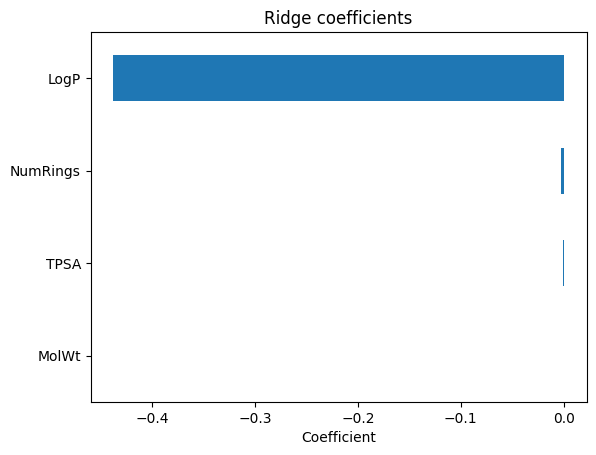

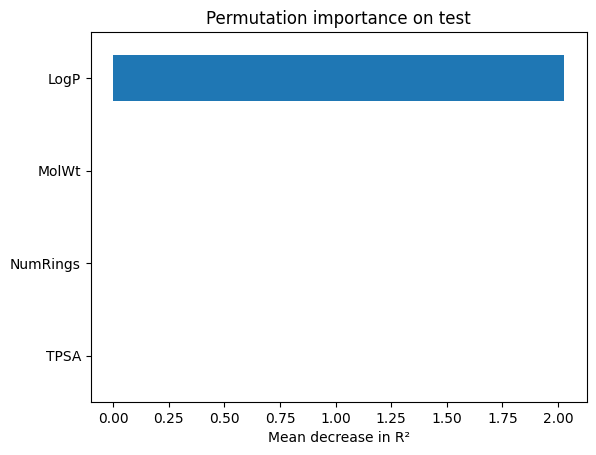

In [23]:
feat = ["MolWt","LogP","TPSA","NumRings"]

coef_ser = pd.Series(ridge_best.coef_, index=feat).sort_values(key=np.abs, ascending=False)
print("Ridge coefficients:\n", coef_ser)
coef_ser.plot(kind="barh"); plt.gca().invert_yaxis()
plt.xlabel("Coefficient"); plt.title("Ridge coefficients"); plt.show()

perm = permutation_importance(ridge_best, X_te, y_te, scoring="r2", n_repeats=30, random_state=1)
perm_ser = pd.Series(perm.importances_mean, index=feat).sort_values()
perm_ser.plot(kind="barh"); plt.xlabel("Mean decrease in R²"); plt.title("Permutation importance on test"); plt.show()